## Pre-processameto de imagens antes de ser aplicado o OCR

##### Fonte: [tutorial](https://www.youtube.com/watch?v=ADV-AjAXHdc&ab_channel=PythonTutorialsforDigitalHumanities) 

In [1]:
# Importação de bibliotecas:

import cv2
import PIL
import pytesseract
import numpy as np
import matplotlib.pyplot as plt
from pdf2image import convert_from_path
from PIL import Image, ImageDraw

### 1. Abrindo um pdf e salvando em formato .jpg: (se fosse o caso)

#### Leitura e visualização do documento em pdf:

doc = convert_from_path(pdf_path = 'images/doc_exemplo.pdf',
                            dpi = 500, fmt = 'jpg', hide_annotations = True)

#### Salvando a imagem (.jpg) em um novo arquivo:

doc_pag1 = doc[0]
doc_pag1.save('images/doc_pag1.jpg')

### 2. Abrindo a imagem salva com o OpenCv:

In [48]:
caminho_imagem = 'images/exemplo.jpg'

ex = cv2.imread(caminho_imagem)

In [49]:
# Função para mostrar a imagem no seu tamanho original com o matplotlib:

def display(im_path):
    dpi = 80
    im_data = plt.imread(im_path)

    height, width  = im_data.shape[:2]
    
    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data, cmap='gray')

    plt.show()

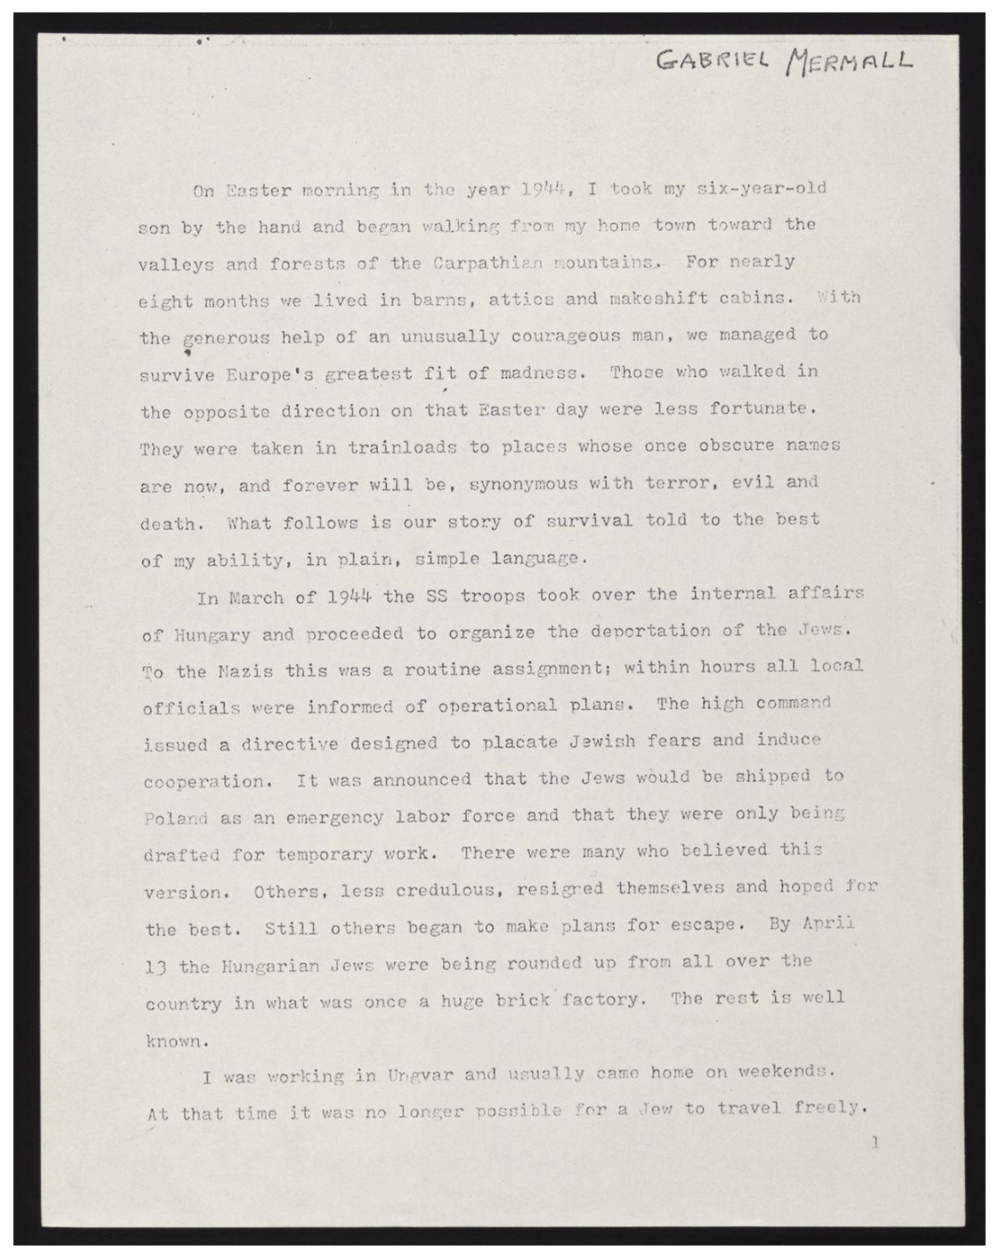

In [50]:
display(caminho_imagem)

### 3. Inverted images: o que é claro se torna escuro e vice-versa.

#### Esse nao é um passo fundamental para o processo, mas às vezes pode ser necessário.

In [51]:
ex_invertido = cv2.bitwise_not(ex)
cv2.imwrite('images/exemplo.jpg', ex_invertido)

True

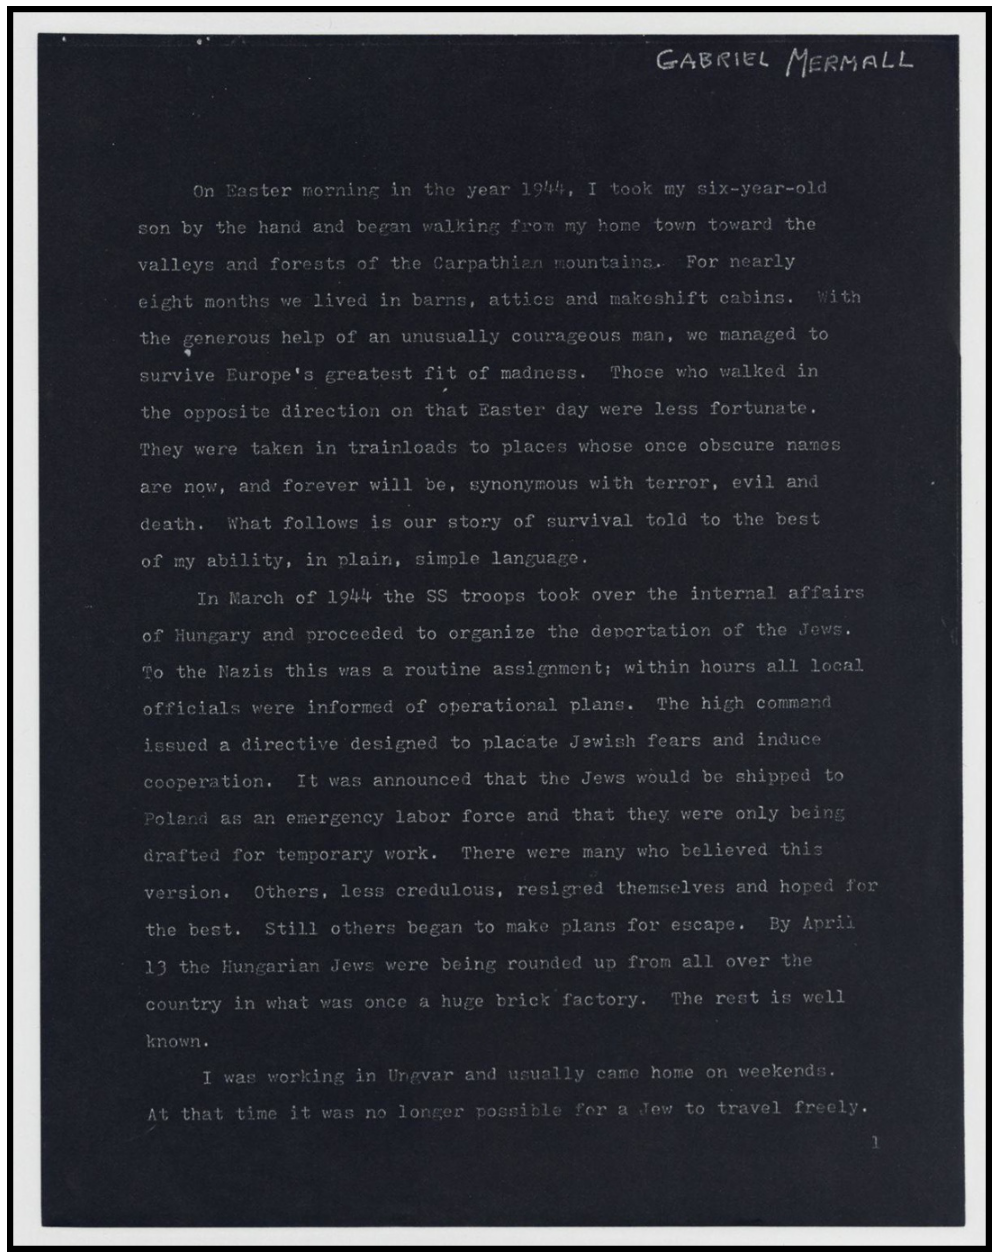

In [52]:
display('images/exemplo.jpg')

### 4. Binarização:

#### 4.1 Escala de cinza:

In [53]:
# Antes de realizar a binarização, passaremos a imagem para a escala de cinzas:

def cinza(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [54]:
# Utilizando a função para a conversão:

ex_cinza = cinza(ex)

# Salvando a imagem:

cv2.imwrite('images/ex_cinza.jpg', ex_cinza)

True

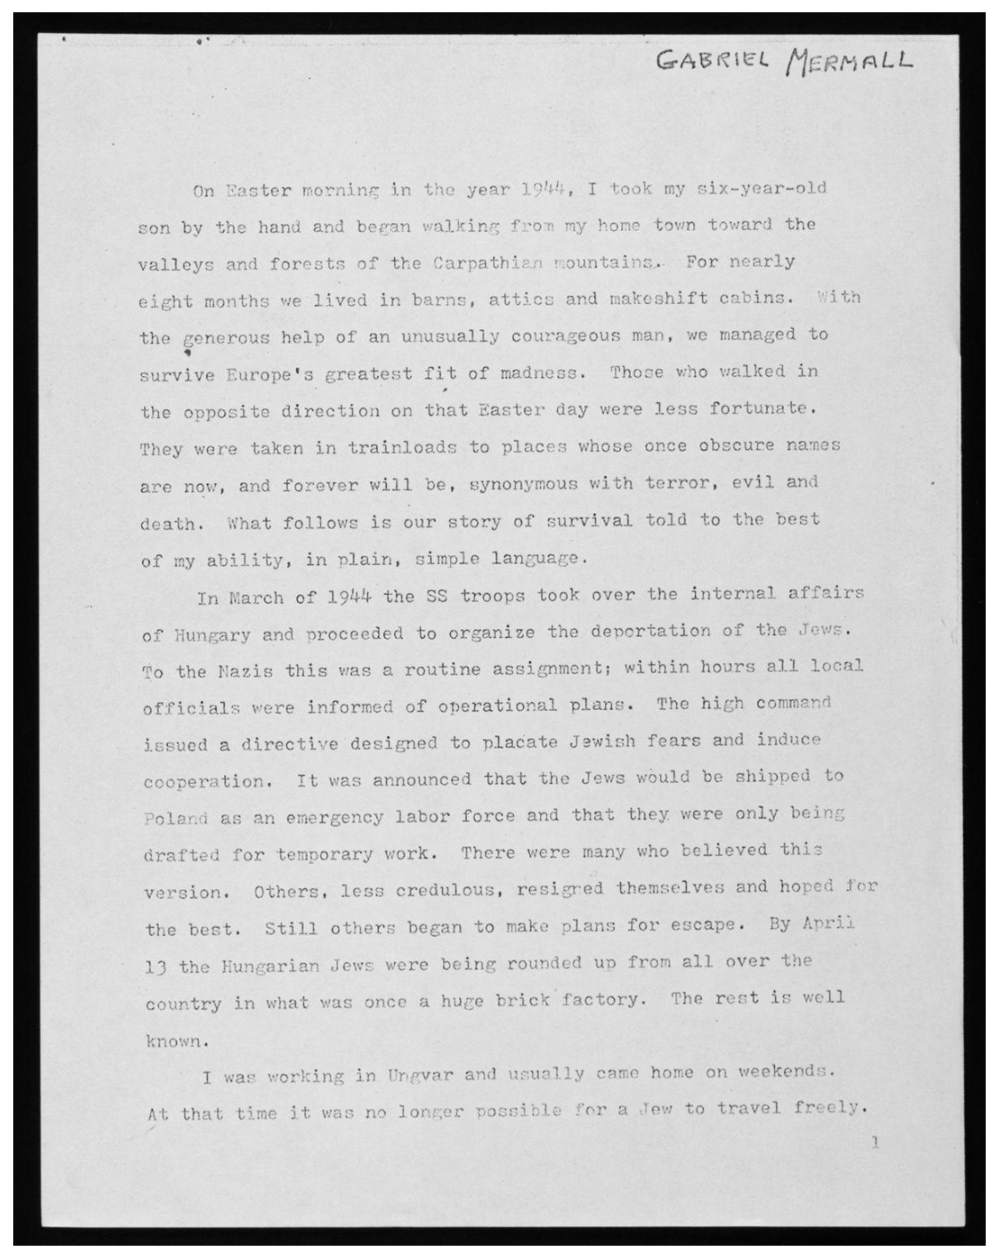

In [55]:
# Utilizando a função display para mostrar a imagem:

display('images/ex_cinza.jpg')

#### 4.2 Binarização:

In [56]:
# Binarização

thresh, ex_bw = cv2.threshold(ex_cinza, 210,230, cv2.THRESH_BINARY)

# Salvando a imagem:
cv2.imwrite('images/ex_bw.jpg', ex_bw)

True

##### Alterar os parâmetros 200, 230 mexe no contraste da imagem.

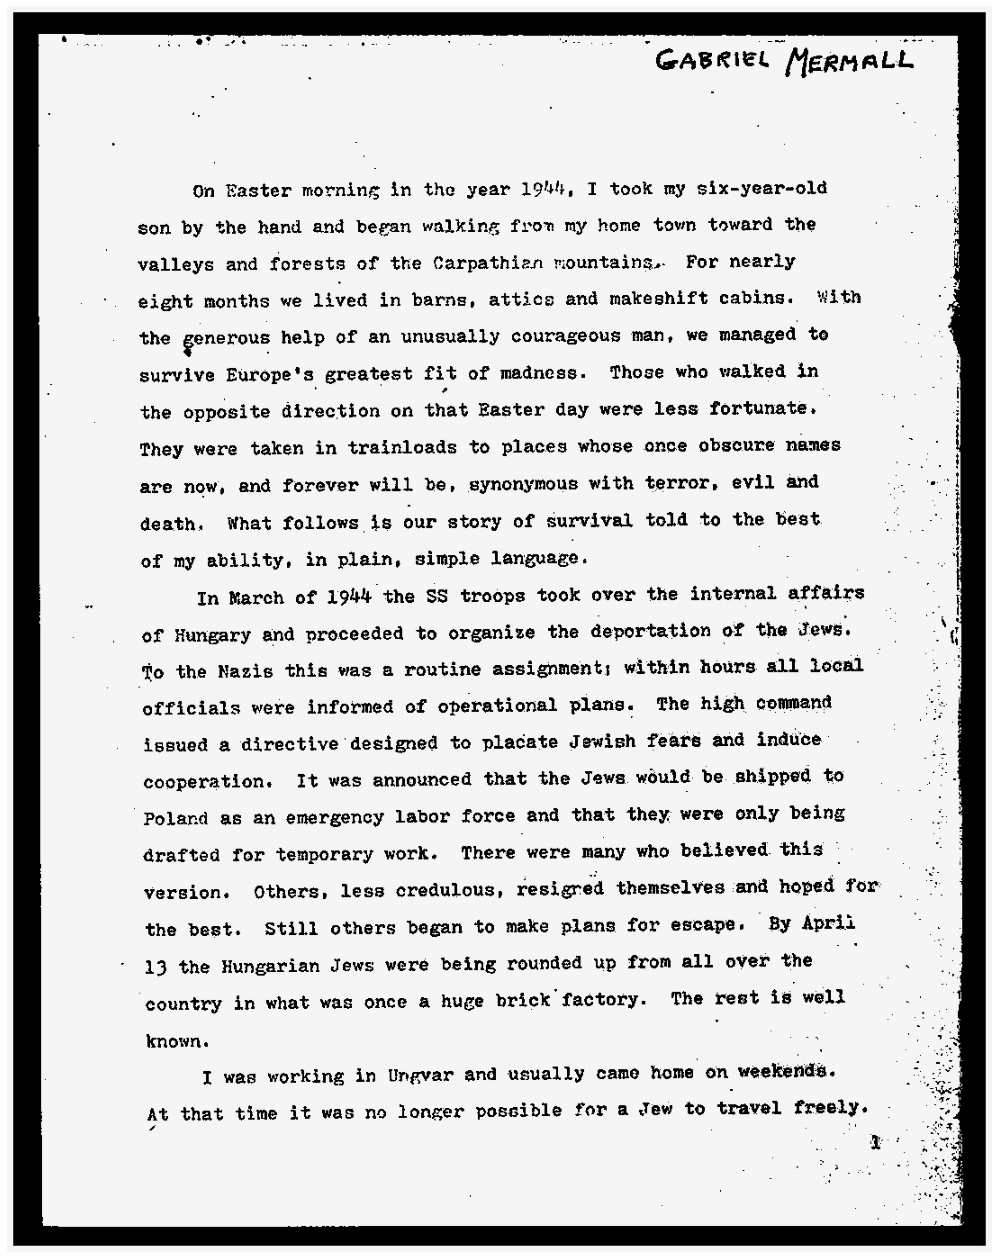

In [57]:
# Utilizando a função display para mostrar a imagem:

display('images/ex_bw.jpg')

### 5. Remoção de ruídos:

#### Nem sempre é vantajoso usar, pode reduzir a nitidez dos caracteres. Analisar caso a caso.

In [58]:
def remover_ruido(image):
    kernel = np.ones((1, 1), np.uint8)
    image = cv2.dilate(image, kernel, iterations=1)
    kernel = np.ones((1, 1), np.uint8)
    image = cv2.erode(image, kernel, iterations=2)
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    image = cv2.medianBlur(image, 3)
    return (image)

In [59]:
# Utilizando a função de remoção de ruídos na imagem bw:

ex_sem_ruido = remover_ruido(ex_bw)

# Salvando a nova imagem:

cv2.imwrite('images/ex_sem_ruido.jpg', ex_sem_ruido)

True

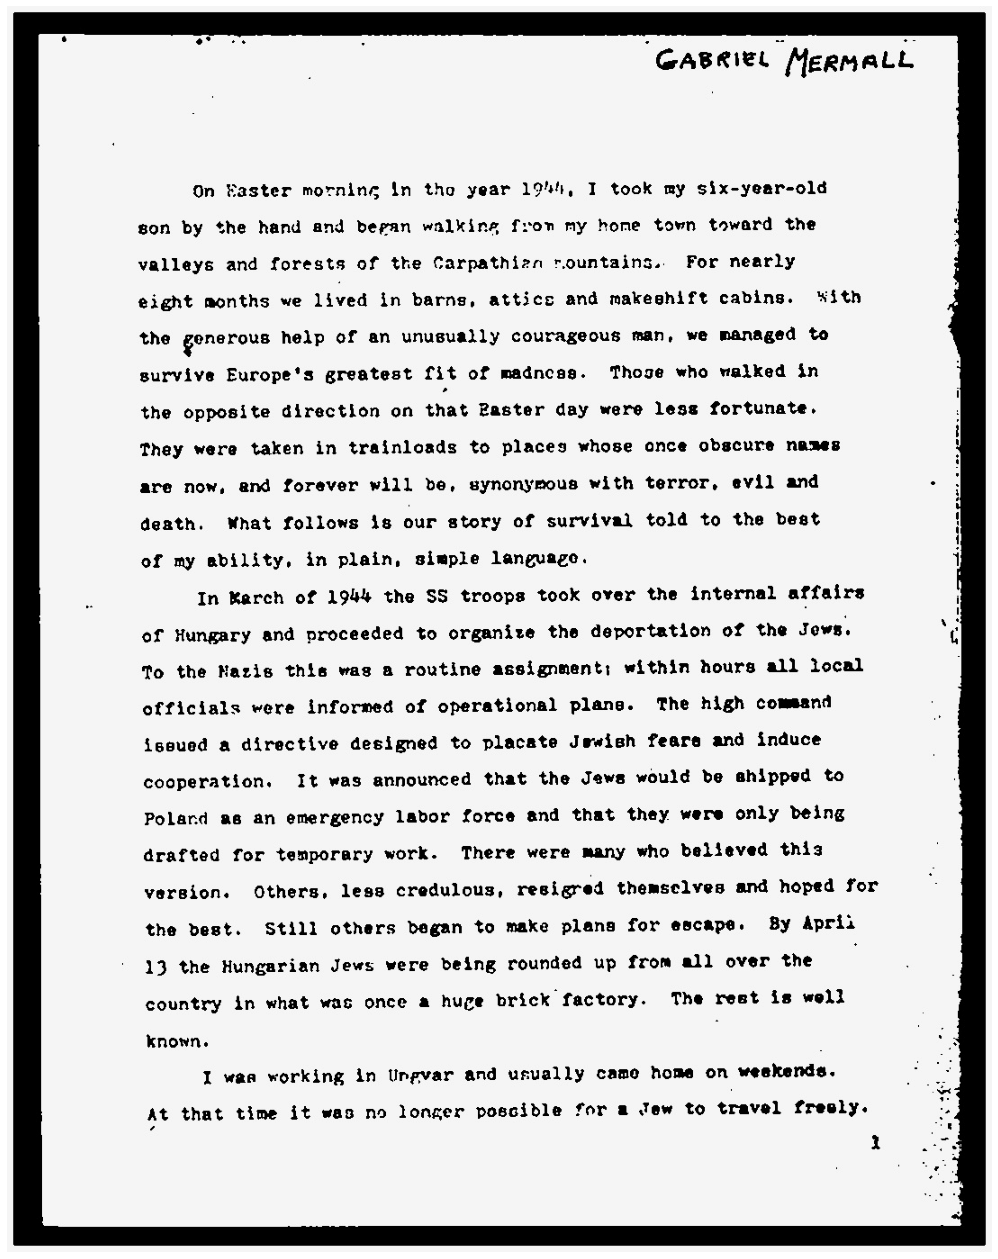

In [60]:
# Mostrando a imagem:

display('images/ex_sem_ruido.jpg')

### 6. Dilatação e erosão:

#### 6.1 Fonte fina:

In [67]:
def fonte_fina(image):
    image = cv2.bitwise_not(image) # Inversão (preto e branco)
    kernel = np.ones((2,2),np.uint8)
    image = cv2.erode(image, kernel, iterations=1)
    image = cv2.bitwise_not(image) # Invertendo novamente (ou seja, revertendo)
    return (image)

In [68]:
# Utilizando a função na imagem resultante da redução de ruído:

ex_fonte_fina = fonte_fina(ex_sem_ruido)
cv2.imwrite('images/ex_fonte_fina.jpg', ex_fonte_fina)

True

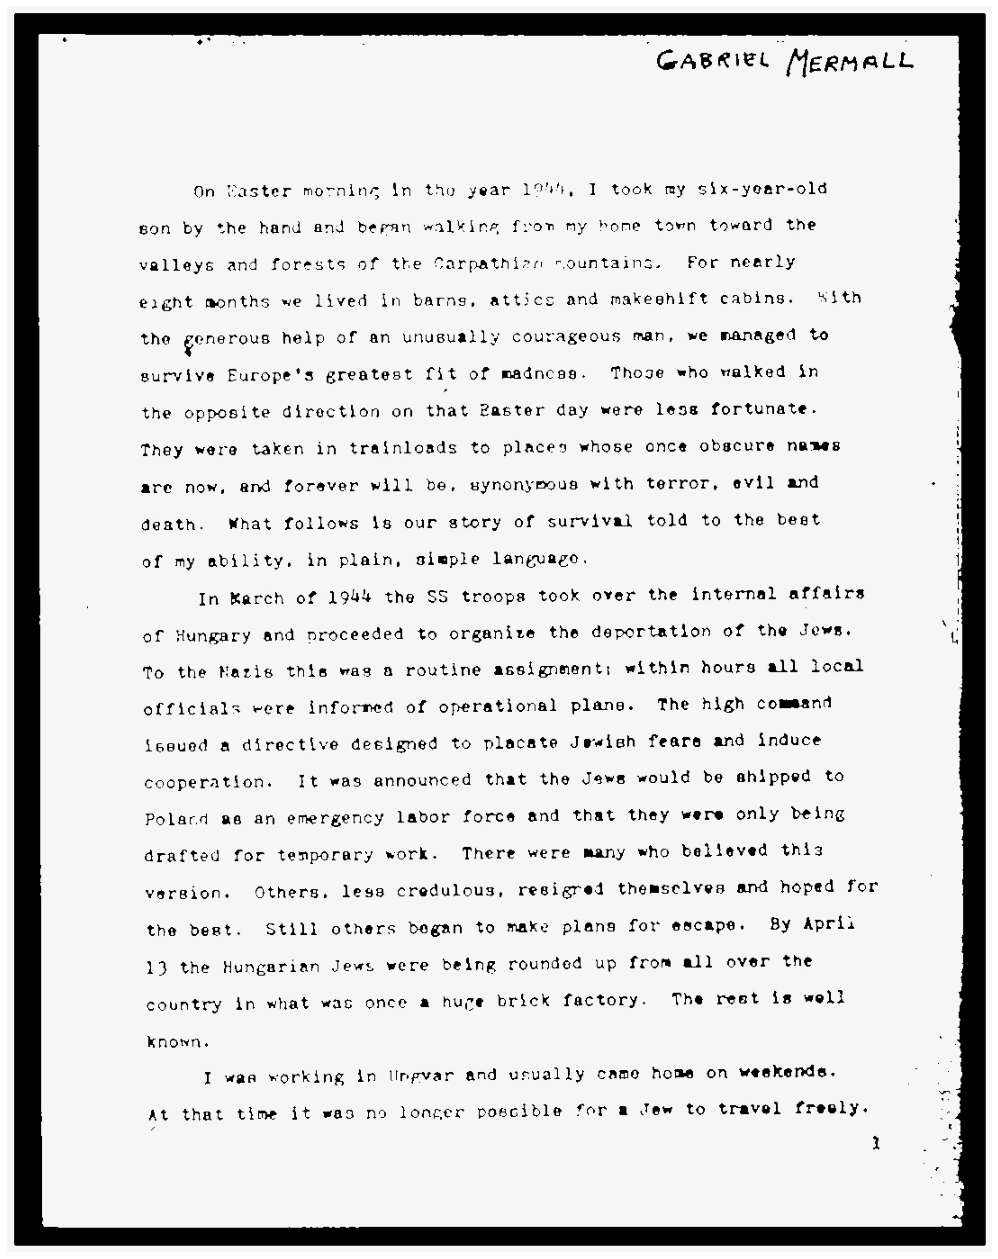

In [71]:
# Mostrando a imagem:

display('images/ex_fonte_fina.jpg')

#### 6.2 Fonte espessa:

In [70]:
def fonte_espessa(image):
    import numpy as np
    image = cv2.bitwise_not(image)
    kernel = np.ones((2,2),np.uint8)
    image = cv2.dilate(image, kernel, iterations=1)
    image = cv2.bitwise_not(image)
    return (image)

In [73]:
ex_fonte_espessa = fonte_espessa(ex_sem_ruido)
cv2.imwrite("images/ex_fonte_espessa.jpg", ex_fonte_espessa)

True

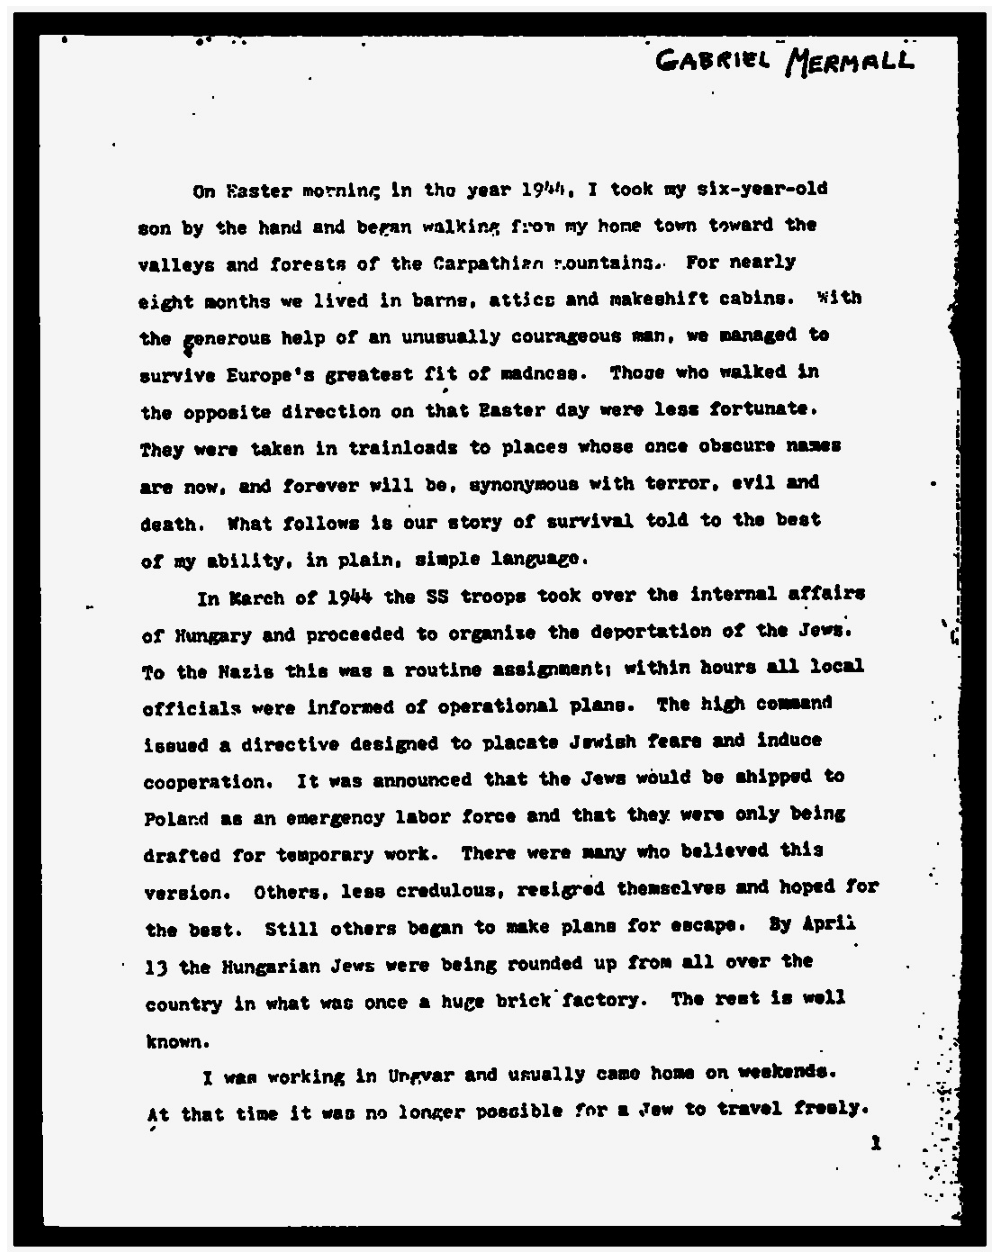

In [74]:
display("images/ex_fonte_espessa.jpg")

### 7. Rotação / Alinhamento:

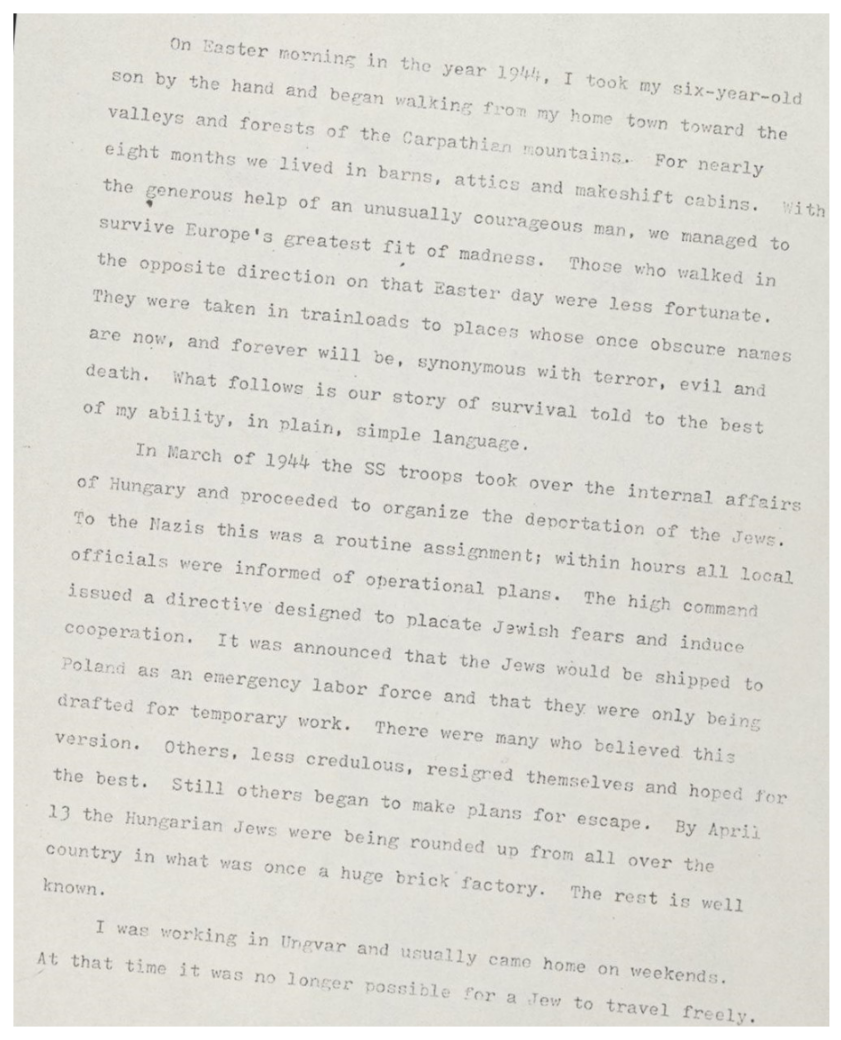

In [75]:
ex2 = cv2.imread("images/ex2.jpg")
display("images/ex2.jpg")

In [80]:
def getSkewAngle(cvImage) -> float:
    # Prep image, copy, convert to gray scale, blur, and threshold
    newImage = cvImage.copy()
    gray = cv2.cvtColor(newImage, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (9, 9), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Apply dilate to merge text into meaningful lines/paragraphs.
    # Use larger kernel on X axis to merge characters into single line, cancelling out any spaces.
    # But use smaller kernel on Y axis to separate between different blocks of text
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 5))
    dilate = cv2.dilate(thresh, kernel, iterations=2)

    # Find all contours
    contours, hierarchy = cv2.findContours(dilate, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)
    for c in contours:
        rect = cv2.boundingRect(c)
        x,y,w,h = rect
        cv2.rectangle(newImage,(x,y),(x+w,y+h),(0,255,0),2)

    # Find largest contour and surround in min area box
    largestContour = contours[0]
    print (len(contours))
    minAreaRect = cv2.minAreaRect(largestContour)
    cv2.imwrite("temp/boxes.jpg", newImage)
    # Determine the angle. Convert it to the value that was originally used to obtain skewed image
    angle = minAreaRect[-1]
    if angle < -45:
        angle = 90 + angle
    return -1.0 * angle
# Rotate the image around its center
def rotateImage(cvImage, angle: float):
    newImage = cvImage.copy()
    (h, w) = newImage.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    newImage = cv2.warpAffine(newImage, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return newImage


In [81]:
# Deskew image
def deskew(cvImage):
    angle = getSkewAngle(cvImage)
    return rotateImage(cvImage, -1.0 * angle)

In [83]:
ex2_alinhada = deskew(ex2)
cv2.imwrite("images/ex2_alinhada.jpg", ex2_alinhada)

28


True

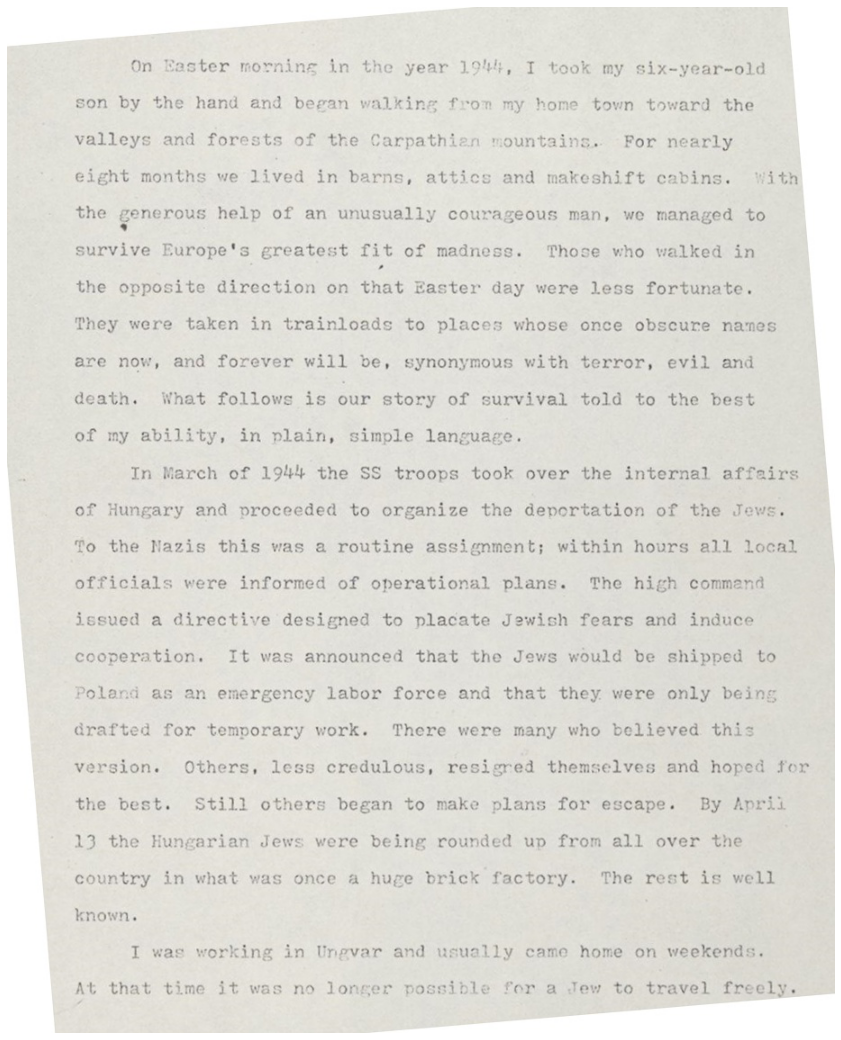

In [84]:
display("images/ex2_alinhada.jpg")